# Task 2

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

/Users/zybell/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
NPI = pd.read_table('Medicare_Physician_and_Other_Supplier_NPI_Aggregate_CY2014.txt')

/Users/zybell/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ultrascores = pd.read_csv('ultrascores.csv')

In [4]:
NPI_ultra = pd.merge(NPI, ultrascores, how='inner', on=['npi'])

In [5]:
NPI_ultra.shape

(4093, 71)

In [6]:
# Look at the columns (variables) of the NPI_ultra matrix
cols = NPI_ultra.columns.tolist()
cols

['npi',
 'nppes_provider_last_org_name',
 'nppes_provider_first_name',
 'nppes_provider_mi',
 'nppes_credentials',
 'nppes_provider_gender',
 'nppes_entity_code',
 'nppes_provider_street1',
 'nppes_provider_street2',
 'nppes_provider_city',
 'nppes_provider_zip',
 'nppes_provider_state',
 'nppes_provider_country',
 'provider_type',
 'medicare_participation_indicator',
 'number_of_hcpcs',
 'total_services',
 'total_unique_benes',
 'total_submitted_chrg_amt',
 'total_medicare_allowed_amt',
 'total_medicare_payment_amt',
 'total_medicare_stnd_amt',
 'drug_suppress_indicator',
 'number_of_drug_hcpcs',
 'total_drug_services',
 'total_drug_unique_benes',
 'total_drug_submitted_chrg_amt',
 'total_drug_medicare_allowed_amt',
 'total_drug_medicare_payment_amt',
 'total_drug_medicare_stnd_amt',
 'med_suppress_indicator',
 'number_of_med_hcpcs',
 'total_med_services',
 'total_med_unique_benes',
 'total_med_submitted_chrg_amt',
 'total_med_medicare_allowed_amt',
 'total_med_medicare_payment_amt',


In [7]:
# Plot target y: ultra_score
# See if ultra_score is close to normal distribution
ultra = NPI_ultra['ultra_score']

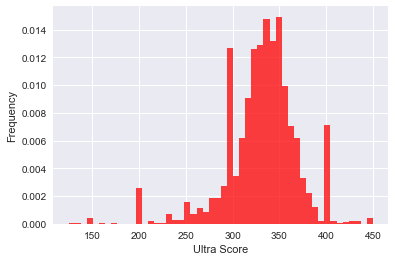

In [8]:
f, ax = plt.subplots()
bins = np.linspace(ultra.min(),ultra.max(),51)
ax = ultra.plot.hist(bins, alpha=0.75, color='red', normed=True)
plt.xlabel('Ultra Score')
plt.ylabel('Frequency')
plt.grid(True)

In [9]:
## Data cleaning
# We need to drop some of the 70 X variables that are not related to ultrascore
# Now let's look at numeric variables first 
num_df = NPI_ultra._get_numeric_data()
# Count non-NA values in each column
num_df.count()

npi                                 4093
number_of_hcpcs                     4093
total_services                      4093
total_unique_benes                  4093
total_submitted_chrg_amt            4093
total_medicare_allowed_amt          4093
total_medicare_payment_amt          4093
total_medicare_stnd_amt             4093
number_of_drug_hcpcs                3197
total_drug_services                 3197
total_drug_unique_benes             3197
total_drug_submitted_chrg_amt       3197
total_drug_medicare_allowed_amt     3197
total_drug_medicare_payment_amt     3197
total_drug_medicare_stnd_amt        3197
number_of_med_hcpcs                 3197
total_med_services                  3197
total_med_unique_benes              3197
total_med_submitted_chrg_amt        3197
total_med_medicare_allowed_amt      3197
total_med_medicare_payment_amt      3197
total_med_medicare_stnd_amt         3197
beneficiary_average_age             4093
beneficiary_age_less_65_count       3978
beneficiary_age_

In [10]:
# Drop the variables with less than 3000 counts, and also drop 'npi' since it is the index
num_df_dropped = num_df.drop(['npi','beneficiary_race_api_count',\
                    'beneficiary_race_hispanic_count','beneficiary_race_natind_count',\
                    'beneficiary_race_other_count'], axis=1) 

In [11]:
# Fill NAs in the dataframe with mean
num_df_NAfilled = num_df_dropped.fillna(num_df_dropped.mean())

In [12]:
num_df_NAfilled.shape

(4093, 50)

In [13]:
# y response is "ultra_score in "num_df_NAfilled" dataframe
y = num_df_NAfilled['ultra_score']

In [14]:
# turn y into categorical data, so that we can split physician peformance into "low", "medium" and "high
y_cat = pd.qcut(y, 3, labels=[1,2,3])

In [15]:
type(y_cat)

pandas.core.series.Series

In [16]:
num_df_NAfilled['y_cat'] = pd.Series(y_cat, index=num_df_NAfilled.index)

In [17]:
num_df_NAfilled.head()

,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,total_medicare_stnd_amt,number_of_drug_hcpcs,total_drug_services,total_drug_unique_benes,...,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,Beneficiary_Average_Risk_Score,ultra_score,y_cat
0,21,3597.0,582,834778.00,417036.56,325817.95,326986.74,0.0,0.0,0.0,...,73.0,75.0,66.0,9.000000,51.0,9.000000,20.0,3.2725,304.9,1
1,11,694.0,131,109613.37,104724.32,80036.72,86654.65,0.0,0.0,0.0,...,49.0,75.0,63.0,7.849304,34.0,8.138881,16.0,4.5405,319.0,1
2,21,2615.0,521,454906.00,232055.25,180751.40,183126.72,0.0,0.0,0.0,...,68.0,75.0,75.0,11.000000,61.0,15.000000,24.0,4.7312,337.0,2
3,15,3138.0,746,412988.45,353156.86,269459.30,268033.46,0.0,0.0,0.0,...,75.0,75.0,70.0,10.000000,42.0,9.000000,8.0,3.0545,350.0,3
4,18,2468.0,421,318125.98,213108.85,164172.04,144577.99,0.0,0.0,0.0,...,68.0,75.0,69.0,5.000000,42.0,5.000000,13.0,4.0852,325.0,2


In [18]:
num_df_NAfilled['y_cat'].value_counts()

1    1375
3    1363
2    1355
Name: y_cat, dtype: int64

In [19]:
# Next we want to do feature selection
# See which ones of the numerical features are important to physician performance
# Feature selection works better with categorical y, so here I will use y_cat as target
# Tree-based feature selection

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier()
X = num_df_NAfilled.drop(['ultra_score','y_cat'],axis=1)
clf = clf.fit(X, y_cat)
impt = clf.feature_importances_
impt

array([ 0.02285962,  0.02230558,  0.02360273,  0.02299418,  0.02106381,
        0.02140753,  0.01940872,  0.01271697,  0.01068608,  0.01213746,
        0.01120426,  0.01316562,  0.01317875,  0.01229615,  0.01814896,
        0.01721585,  0.01805766,  0.01915027,  0.01689216,  0.01893771,
        0.01756675,  0.02330114,  0.02598489,  0.02501048,  0.02104178,
        0.02389328,  0.02259035,  0.020968  ,  0.02296245,  0.02981321,
        0.02335686,  0.02253933,  0.02292424,  0.0238572 ,  0.02475569,
        0.0256494 ,  0.0245282 ,  0.00627054,  0.02565676,  0.02532027,
        0.02279371,  0.02367457,  0.00131728,  0.02498244,  0.02341819,
        0.02452191,  0.02511241,  0.02549126,  0.02326731])

In [20]:
non_feature_impt = pd.DataFrame(
    {'feature': X.columns.tolist (),
     'impt': impt,
    })

In [21]:
top_feature = non_feature_impt.sort_values(['impt'],ascending = [0]).head(33)
top_feature

,feature,impt
29,beneficiary_race_black_count,0.029813
22,beneficiary_age_less_65_count,0.025985
38,beneficiary_cc_copd_percent,0.025657
35,beneficiary_cc_cancer_percent,0.025649
47,beneficiary_cc_strk_percent,0.025491
39,beneficiary_cc_depr_percent,0.025320
46,beneficiary_cc_schiot_percent,0.025112
23,beneficiary_age_65_74_count,0.025010
43,beneficiary_cc_ihd_percent,0.024982
34,beneficiary_cc_asthma_percent,0.024756


Looks like "beneficiary" related features are more important in this model

In [22]:
num_df_NAfilled.head()

,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,total_medicare_stnd_amt,number_of_drug_hcpcs,total_drug_services,total_drug_unique_benes,...,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,Beneficiary_Average_Risk_Score,ultra_score,y_cat
0,21,3597.0,582,834778.00,417036.56,325817.95,326986.74,0.0,0.0,0.0,...,73.0,75.0,66.0,9.000000,51.0,9.000000,20.0,3.2725,304.9,1
1,11,694.0,131,109613.37,104724.32,80036.72,86654.65,0.0,0.0,0.0,...,49.0,75.0,63.0,7.849304,34.0,8.138881,16.0,4.5405,319.0,1
2,21,2615.0,521,454906.00,232055.25,180751.40,183126.72,0.0,0.0,0.0,...,68.0,75.0,75.0,11.000000,61.0,15.000000,24.0,4.7312,337.0,2
3,15,3138.0,746,412988.45,353156.86,269459.30,268033.46,0.0,0.0,0.0,...,75.0,75.0,70.0,10.000000,42.0,9.000000,8.0,3.0545,350.0,3
4,18,2468.0,421,318125.98,213108.85,164172.04,144577.99,0.0,0.0,0.0,...,68.0,75.0,69.0,5.000000,42.0,5.000000,13.0,4.0852,325.0,2


In [23]:
# Visualize the correlation between top features after feature selection
# Calculate spearman correlation 
impt_feature = num_df_NAfilled[top_feature.feature].join(num_df_NAfilled['ultra_score'].to_frame())
spearman = impt_feature.corr(method='spearman')

In [24]:
# Look at the correlation between input attributes and the response y (ultra_score)
# Ultra_score is the last, then remove corr with itself
corr_with_y = spearman.ix[-1][:-1]
# attributes sorted from the most predictive
#predictivity = corr_with_target.sort_values(ascending=False)
predictivity= corr_with_y[abs(corr_with_y).argsort()[::-1]]

In [25]:
spearman

,beneficiary_race_black_count,beneficiary_age_less_65_count,beneficiary_cc_copd_percent,beneficiary_cc_cancer_percent,beneficiary_cc_strk_percent,beneficiary_cc_depr_percent,beneficiary_cc_schiot_percent,beneficiary_age_65_74_count,beneficiary_cc_ihd_percent,beneficiary_cc_asthma_percent,...,beneficiary_cc_diab_percent,beneficiary_female_count,beneficiary_dual_count,total_services,total_medicare_payment_amt,total_medicare_allowed_amt,beneficiary_age_75_84_count,beneficiary_male_count,total_medicare_stnd_amt,ultra_score
beneficiary_race_black_count,1.000000,0.430855,0.011532,-0.116755,0.135088,-0.126980,0.046668,0.186726,0.029764,0.041018,...,0.269220,0.227824,0.380747,0.140783,0.221061,0.218676,0.055762,0.176007,0.232356,-0.099028
beneficiary_age_less_65_count,0.430855,1.000000,0.040033,-0.276094,-0.082744,0.012949,-0.083224,0.674153,0.021938,-0.113661,...,0.183774,0.708226,0.773224,0.485888,0.555824,0.557518,0.476147,0.719687,0.586649,-0.054441
beneficiary_cc_copd_percent,0.011532,0.040033,1.000000,0.355657,0.502289,0.585687,0.486527,0.113386,0.627368,0.381956,...,0.134792,0.169286,0.169349,0.020139,0.078366,0.072866,0.149386,0.129064,0.077287,-0.097043
beneficiary_cc_cancer_percent,-0.116755,-0.276094,0.355657,1.000000,0.378773,0.162590,0.167627,0.053051,0.317836,0.233196,...,-0.221042,0.064736,-0.187422,0.006594,0.005763,0.002531,0.180528,0.077417,-0.021696,0.004584
beneficiary_cc_strk_percent,0.135088,-0.082744,0.502289,0.378773,1.000000,0.339848,0.444376,-0.138997,0.586657,0.493808,...,0.316611,-0.068961,0.075761,-0.112380,-0.016123,-0.024259,-0.080506,-0.092146,-0.046302,-0.043147
beneficiary_cc_depr_percent,-0.126980,0.012949,0.585687,0.162590,0.339848,1.000000,0.533397,-0.102862,0.397757,0.401821,...,0.037882,-0.054381,0.043562,-0.150719,-0.167956,-0.173660,-0.083842,-0.064777,-0.163958,-0.088445
beneficiary_cc_schiot_percent,0.046668,-0.083224,0.486527,0.167627,0.444376,0.533397,1.000000,-0.228141,0.358440,0.416481,...,0.174543,-0.155282,0.078572,-0.182801,-0.130801,-0.136529,-0.195586,-0.202915,-0.132874,-0.110683
beneficiary_age_65_74_count,0.186726,0.674153,0.113386,0.053051,-0.138997,-0.102862,-0.228141,1.000000,0.028293,-0.240083,...,-0.095616,0.943166,0.624865,0.673976,0.689530,0.694472,0.853384,0.939502,0.707331,-0.002644
beneficiary_cc_ihd_percent,0.029764,0.021938,0.627368,0.317836,0.586657,0.397757,0.358440,0.028293,1.000000,0.378818,...,0.402757,0.090814,0.182973,0.020158,0.131668,0.124135,0.067904,0.108581,0.112451,-0.053300
beneficiary_cc_asthma_percent,0.041018,-0.113661,0.381956,0.233196,0.493808,0.401821,0.416481,-0.240083,0.378818,1.000000,...,0.294520,-0.199665,0.014859,-0.197345,-0.163068,-0.168364,-0.226427,-0.228977,-0.184151,-0.061829


In [26]:
predictivity

beneficiary_cc_schiot_percent      -0.110683
beneficiary_race_black_count       -0.099028
beneficiary_cc_copd_percent        -0.097043
beneficiary_cc_depr_percent        -0.088445
beneficiary_cc_raoa_percent        -0.067442
beneficiary_cc_asthma_percent      -0.061829
beneficiary_cc_chf_percent         -0.060237
beneficiary_age_less_65_count      -0.054441
beneficiary_cc_ihd_percent         -0.053300
beneficiary_average_age             0.047167
beneficiary_cc_strk_percent        -0.043147
total_services                      0.042222
beneficiary_age_greater_84_count    0.040109
beneficiary_cc_alzrdsd_percent     -0.036967
beneficiary_dual_count             -0.035704
total_medicare_allowed_amt          0.032717
total_medicare_payment_amt          0.031609
beneficiary_cc_ost_percent          0.026678
beneficiary_age_75_84_count         0.025467
total_medicare_stnd_amt             0.023800
Beneficiary_Average_Risk_Score      0.021688
total_unique_benes                 -0.018720
beneficiar

The predictivity is in general low between each numerial X variable and ultrascore

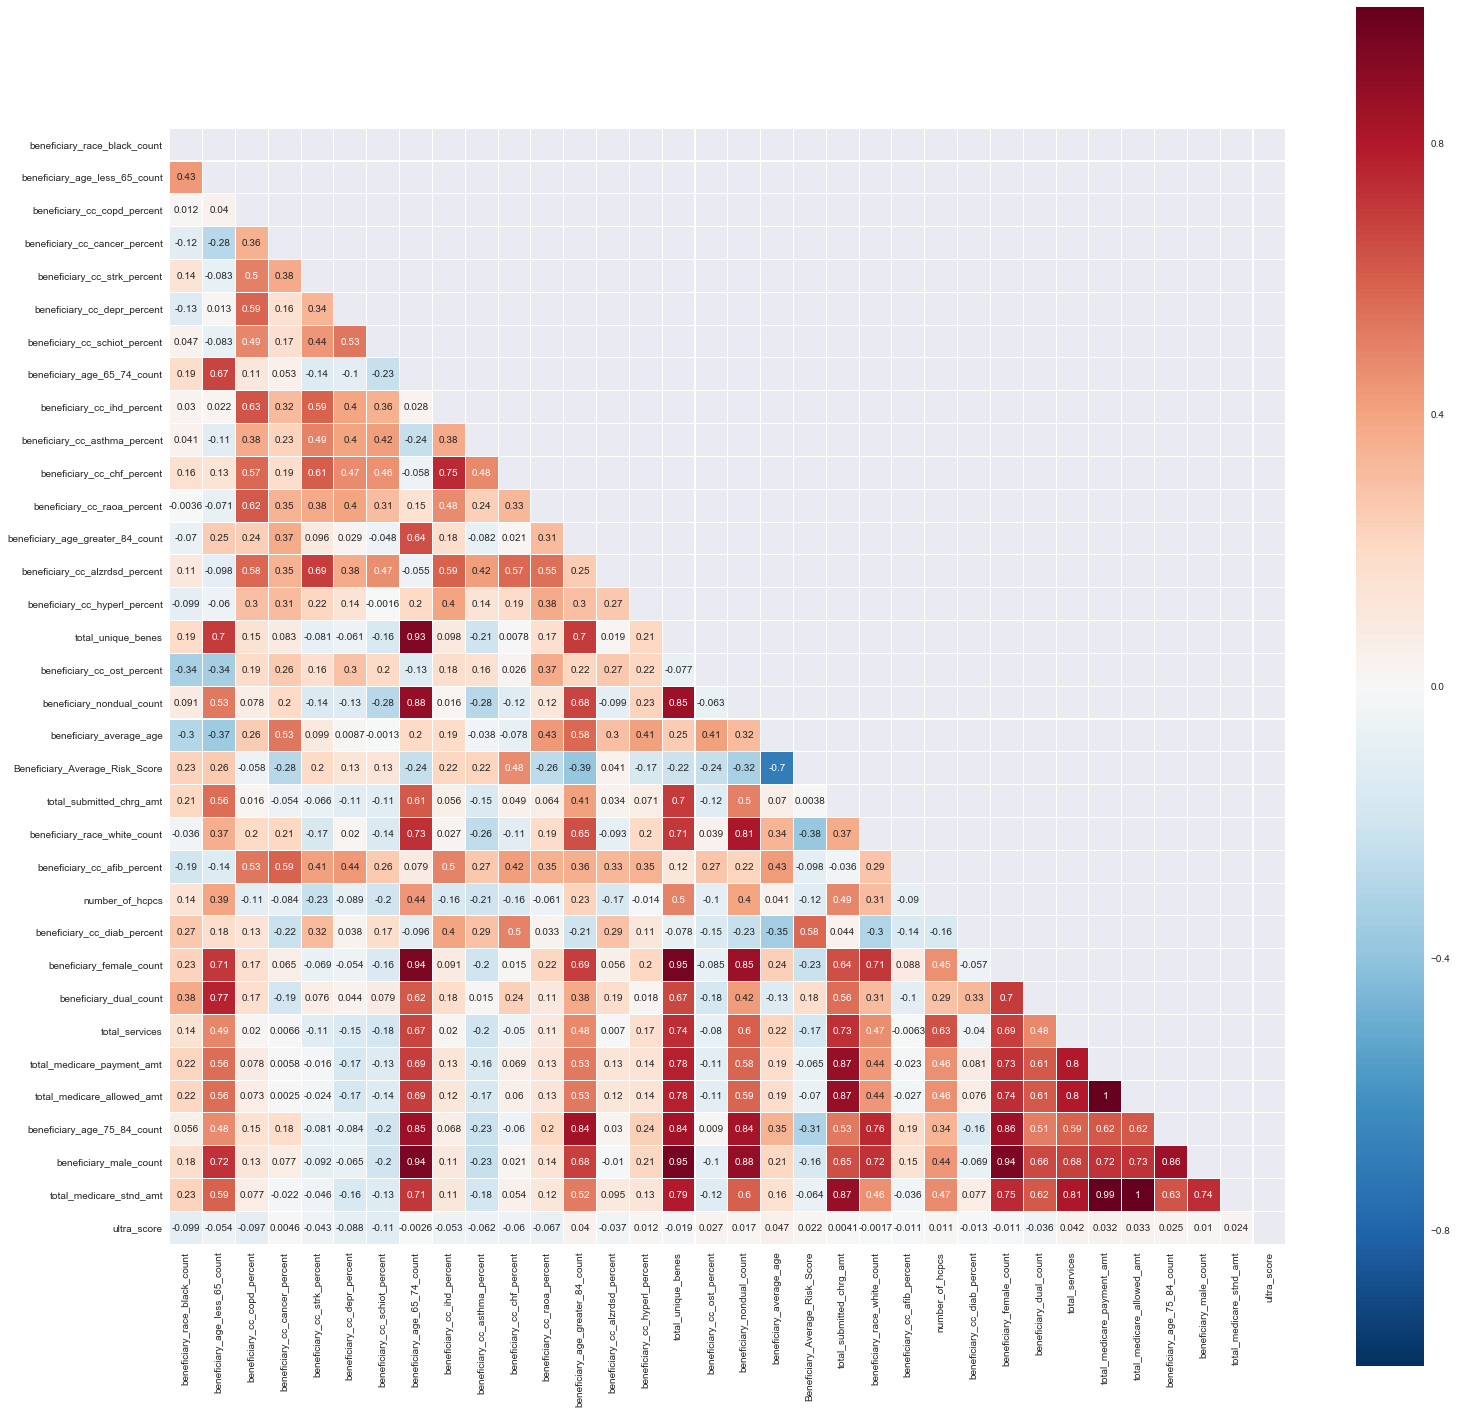

In [27]:
# Visualize the spearman correlation matrix
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# The correlation matrix spearman computed
# Generate a mask for the upper triangle
mask = np.zeros_like(spearman, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.heatmap(spearman, mask = mask, vmax=.8, square=True)

sns.heatmap(spearman, vmin=spearman.values.min(), mask = mask, vmax=1, square=True, 
        linewidths=0.1, annot=True, annot_kws={"size":10})

Feature selection did reduce the high correlation among some features. 
None of the numerical X variables seem to be highly correlated with ultra_score.
Here are the top features that are negatively correlated with ultra_score.
1. beneficiary_cc_schiot_percent      -0.110683
2. beneficiary_race_black_count       -0.099028
3. beneficiary_cc_copd_percent        -0.097043
4. beneficiary_cc_depr_percent        -0.088445

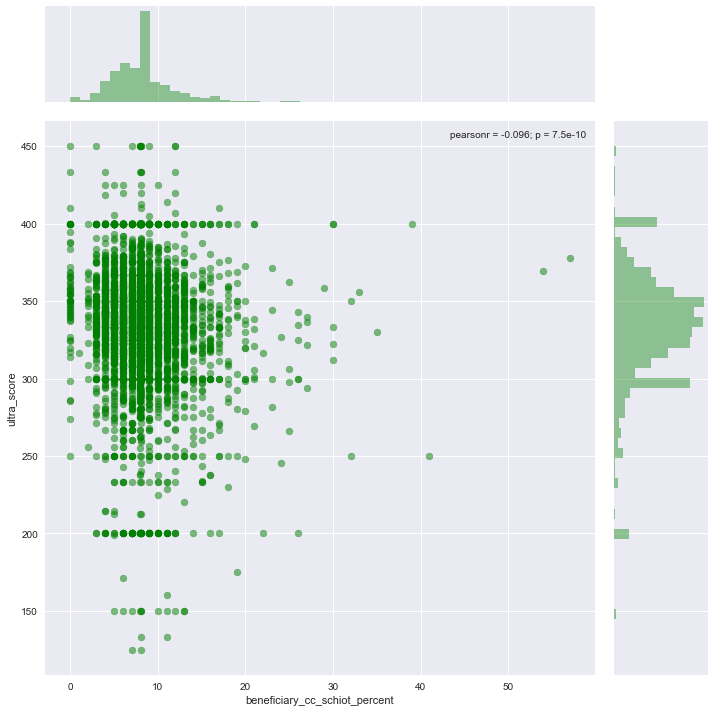

In [28]:
# Plot the correlation between 'beneficiary_cc_schiot_percent' and 'ultra_score'
# Pair-wise joint plots

x = impt_feature['beneficiary_cc_schiot_percent']
y = impt_feature['ultra_score']
sns.jointplot(x, y, kind='scatter', size=10, joint_kws={'alpha':0.5}, color="g")

Now let's explore categorical variables.
The most interesting categorical variables are the following: 
#(1) Credentials of the provider
#(2) Gender of the provider
#(3) Country code of the provider 
#(4) State code of the provider

In [29]:
NPI_ultra['nppes_credentials'].value_counts().head()
# Almost all M.Ds, not much differentiation

M.D.    1826
MD      1764
D.O.     129
M.D       98
DO        93
Name: nppes_credentials, dtype: int64

In [30]:
NPI_ultra['nppes_provider_gender'].value_counts()

M    3143
F     950
Name: nppes_provider_gender, dtype: int64

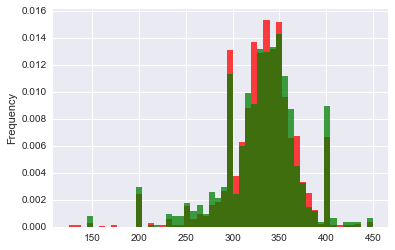

In [31]:
# Plot out ultrasouce for both genders as histograms

bins = np.linspace(NPI_ultra.ultra_score.min(),NPI_ultra.ultra_score.max(),51)
ax = NPI_ultra[NPI_ultra['nppes_provider_gender']=='M'].ultra_score.plot.hist(bins, alpha=0.75, label='Male', color='red', normed=True)
ax2 = NPI_ultra[NPI_ultra['nppes_provider_gender']=='F'].ultra_score.plot.hist(bins,alpha=0.75, label='Female', color='green', normed=True)

In [32]:
NPI_ultra['nppes_provider_country'].value_counts()
# All from US

US    4093
Name: nppes_provider_country, dtype: int64

In [33]:
NPI_ultra['medicare_participation_indicator'].value_counts()
# All with Y at medicare_participation_indicator

Y    4093
Name: medicare_participation_indicator, dtype: int64

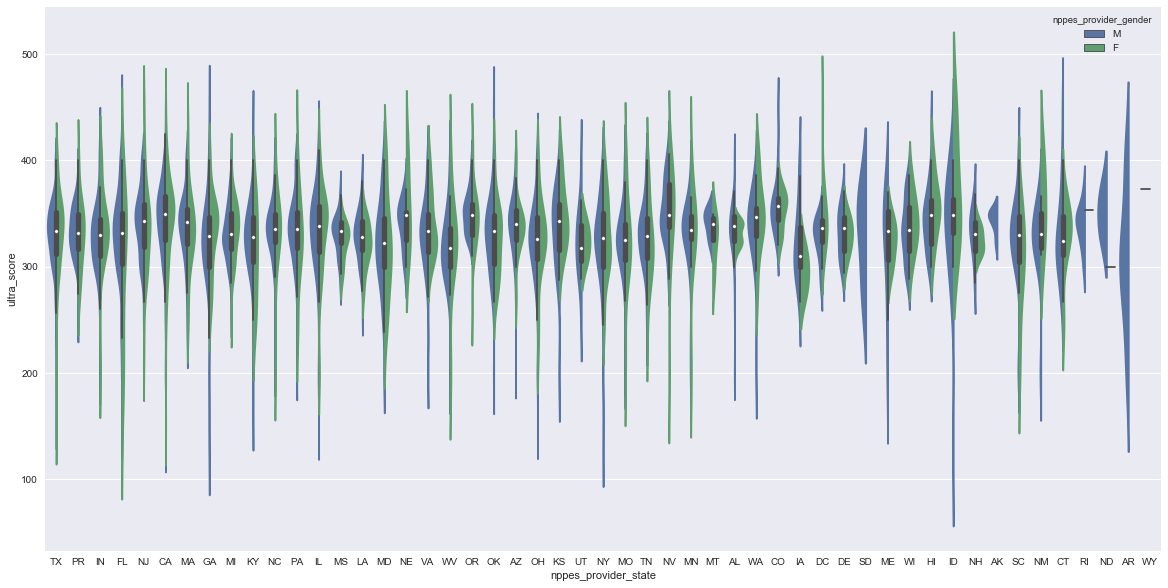

In [34]:
# Plot the ultra_score of physicians from each state
f, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(x="nppes_provider_state", y="ultra_score", hue="nppes_provider_gender", data=NPI_ultra, split=True);

I also did not find categorical variables correlated with physicians' ultrascore
(1) Credentials of the provider seem to be M.D. for majority
(2) Male and female providers show overlap of distribution on histogram
(3) Providers all come from U.S.
(4) There is very tiny differences among state codes of providers

To better find patterns among high-performing physicians or low-performing physicians, I choose to do the following:
(1) Drop the median-performing physicians
(2) Use LDA to see the factors differentiating low and high physicians

In [35]:
NPI_ultra['y_cat'] = pd.Series(y_cat, index=NPI_ultra.index)
# Append y_cat into the original dataset

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = num_df_NAfilled.drop(['ultra_score','y_cat'], axis = 1)
y = y_cat.values

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit_transform(X, y)

target_names = ['low', 'medium', 'high']

/Users/zybell/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


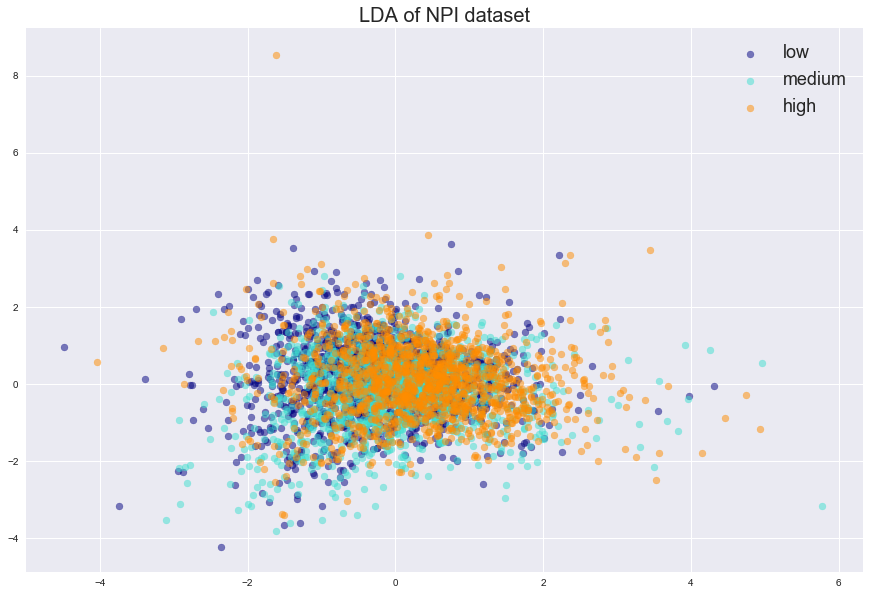

In [37]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from matplotlib import pyplot as plt

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2


plt.figure(figsize=(15, 10))
for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=18)
plt.title('LDA of NPI dataset', fontsize = 20)

plt.show()

According to LDA result, there is no clear seperation between high and low performance groups

In [38]:
var_exp = lda.explained_variance_ratio_ 
var_exp

array([ 0.69905819,  0.30094181])

In [39]:
# Look at the coefficients of LDA to see which variables are contributing
coefficients = lda.coef_ 

In [40]:
coffLow = coefficients[0]

In [41]:
coffHigh = coefficients[2]

In [42]:
LDA_coeff = pd.DataFrame(
    {'coffLow': coffLow,
     'coffHigh': coffHigh,
     'feature': X.columns.tolist (),
    }).sort_values(['coffHigh'], ascending = [0])

In [43]:
LDA_coeff

,coffHigh,coffLow,feature
48,1.137608e-01,-2.205980e-01,Beneficiary_Average_Risk_Score
7,3.260818e-02,-4.872519e-02,number_of_drug_hcpcs
21,2.391455e-02,-3.506027e-02,beneficiary_average_age
44,1.804193e-02,-5.097450e-03,beneficiary_cc_ost_percent
35,1.431543e-02,-3.494221e-05,beneficiary_cc_cancer_percent
40,7.862733e-03,1.349935e-03,beneficiary_cc_diab_percent
25,3.077376e-03,-1.729155e-03,beneficiary_age_greater_84_count
39,2.849872e-03,6.020701e-03,beneficiary_cc_depr_percent
33,2.819322e-03,-6.536272e-03,beneficiary_cc_alzrdsd_percent
27,2.591563e-03,-2.137983e-03,beneficiary_male_count


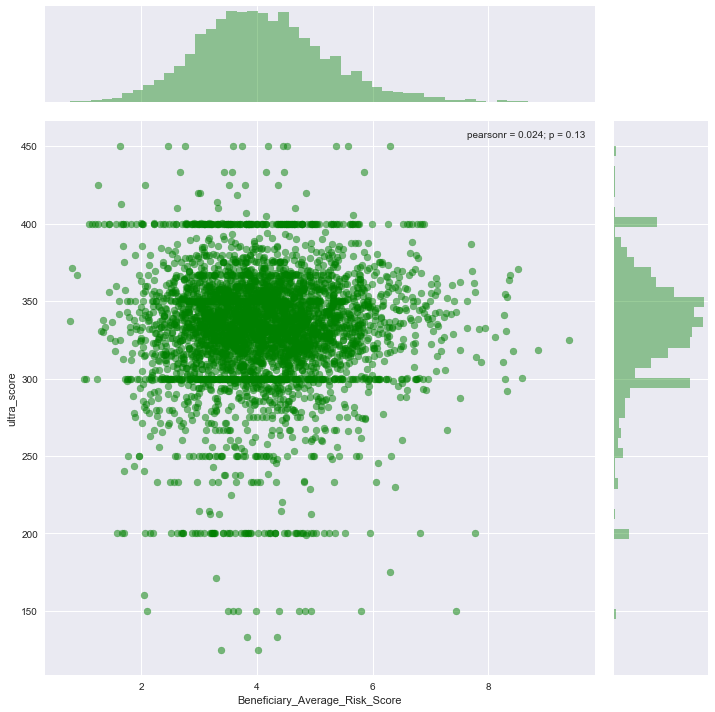

In [44]:
# Let's plot the correlation between "Beneficiary_Average_Risk_Score" and "ultrascore"
x = impt_feature['Beneficiary_Average_Risk_Score']
y = impt_feature['ultra_score']
sns.jointplot(x, y, kind='scatter', size=10, joint_kws={'alpha':0.5}, color="g")